# Handwriting recognition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

## Data import and visualization

Import the MNIST train dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database))

In [2]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt("mnist_train_small.csv", delimiter=",")
data.shape

(20000, 785)

Store the data in a matrix and the labels in a vector.

In [3]:
labels = data[:, 0]
x_data = data[:, 1:] / 255
labels.shape, x_data.shape

((20000,), (20000, 784))

Visualize the first 30 pictures with the corresponding labels

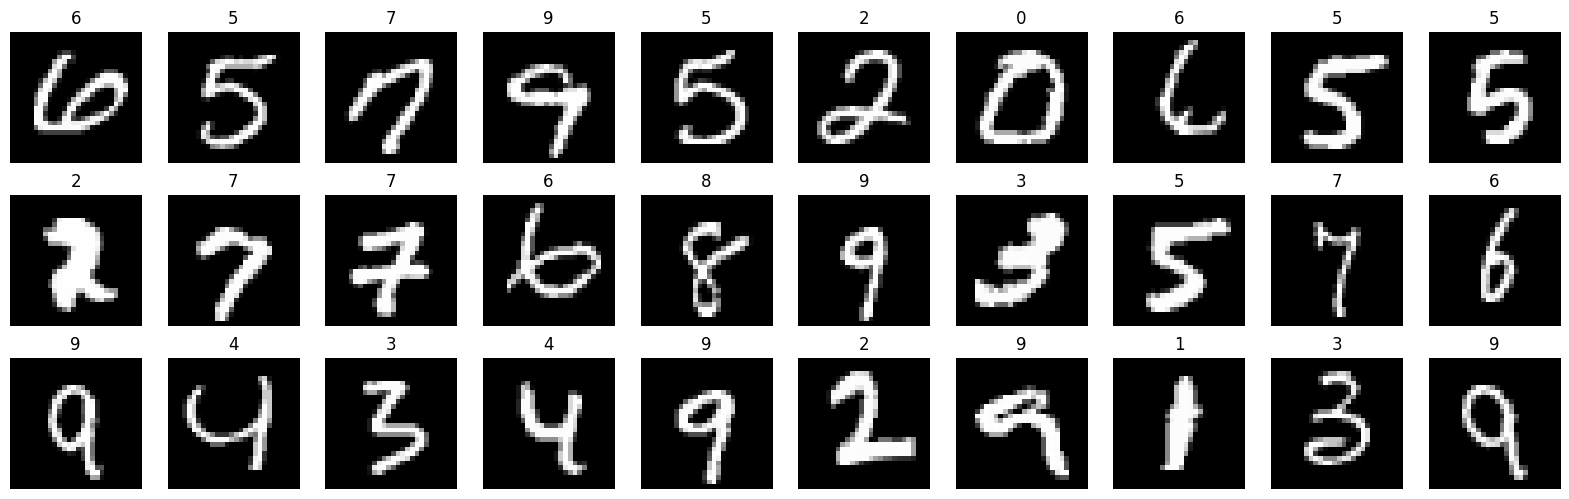

In [4]:
fig, axs = plt.subplots(ncols = 10, nrows = 3, figsize = (20,6))
axs = axs.reshape((-1,))
for i in range(30):
  image_i = x_data[i].reshape((28,28))
  axs[i].imshow(image_i, cmap='gray')
  axs[i].set_title(int(labels[i]))
  axs[i].axis('off')

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.

In [5]:
y_data = np.zeros((20000, 10))
for i in range(len(y_data)):
  y_data[i][int(labels[i])] = 1
y_data.shape # Each row has a 1 in the position corresponding to the correct label.

(20000, 10)

Check that the matrix has exactly one element "1" in each column.

In [6]:
row_sums = np.sum(y_data, axis = 1)
row_sums.min(), row_sums.max()

(1.0, 1.0)

## ANN training

Write a function to initialize the parameters (with Glorot Normal initialization) and a function implementing a feedforward ANN with tanh activation function.

To the last layer of the ANN, apply a *soft-max* layer. If $z_1, \dots, z_n$ are the activations of the last layer neurons, the soft-max layer produces $\hat{z}_1, \dots, \hat{z}_n$, defined as
$$
\hat{z}_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$
In this manner the outputs of the ANN satisfy by construction:
- $\hat{z}_i \in [0,1]$
- $\sum_{j=1}^n \hat{z}_j = 1$

Therefore, they can be intepreted as probabilities.

When the ANN will be trained, we will take the digit corresponding the the hightest proabability as prediction of the model.

In [7]:
def initialize(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    n, m = layers_size[i + 1], layers_size[i]
    params.append(np.random.normal(0, np.sqrt(2 / (n + m)), (n, m)))
    params.append(np.zeros((n, 1)))
  return params

In [8]:
def ANN(x, params):
    temp = x.T
    for i in range(0, len(params), 2):
      if i == len(params) - 2:
        temp = params[i] @ temp + params[i + 1]
      else:
        temp = jnp.tanh(params[i] @ temp + params[i + 1])
    res = jax.lax.map(lambda v: jnp.exp(v) / jnp.sum(jnp.exp(v)) , temp.T)
    return res

Test the ANN and check that the above properties are satisfied.

In [9]:
pred = ANN(x_data, initialize([784, 64, 32, 16, 10]))
print(pred[0].sum(), pred[0][2]) # You deduce that the prediction won't be 2.
pred.shape

1.0 0.07934591


(20000, 10)

Implement the following metrics:
- mean square error
- cross entropy
- accuracy (fraction of samples correctly classified)

In [10]:
def MSE(x, y, params):
  pred = ANN(x, params)
  return jnp.mean(
    jax.lax.map(
      lambda i: jnp.mean(jnp.square(pred[i] - y[i])), jnp.array(range(len(y)))
    )
  )

MSE_fast = jax.jit(MSE)

def cross_entropy(x, y, params):
  pred = ANN(x, params)
  err = jax.lax.map(lambda i: jnp.sum(jnp.log(pred[i]) * y[i]), jnp.array(range(len(y))))
  return jnp.mean(-err)

cross_entropy_fast = jax.jit(cross_entropy)

def accuracy(x, y, params):
  pred = ANN(x, params)
  wrong = jnp.mean(
    jax.lax.map(lambda i: jnp.sign(jnp.absolute(jnp.argmax(pred[i]) - jnp.argmax(y[i]))), jnp.array(range(len(y))))
  )
  return 1 - wrong

accuracy_fast = jax.jit(accuracy)

params = initialize([784, 64, 32, 16, 10])
print('MSE:       %f' % MSE_fast(x_data, y_data, params))
print('Cross entropy: %f' % cross_entropy_fast(x_data, y_data, params))
print('Accuracy:  %f' % accuracy_fast(x_data, y_data, params))

MSE:       0.091300
Cross entropy: 2.357758
Accuracy:  0.137450


Put 10000 images in the training set and 10000 images in the validation set.

In [11]:
train_num, test_num = 10000, 10000
x_train, y_train, x_test, y_test = x_data[:train_num], y_data[:train_num], x_data[train_num:], y_data[train_num:]

Run this cell. We will use it later.

In [12]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      epochs = np.arange(1,len(history_train_Xen) + 1)
      self.axs.loglog(epochs, history_train_Xen, label = 'train_Xen')
      self.axs.loglog(epochs, history_valid_Xen, label = 'valid_Xen')
      self.axs.loglog(epochs, history_valid_MSE, label = 'valid_MSE')
      self.axs.loglog(epochs, history_valid_acc, label = 'valid_acc')

      self.axs.legend()
      self.axs.set_title('epoch %d - accuracy %0.1f%%' % (self.epoch + 1, 100 * history_valid_acc[-1]))

Train an ANN-based classifier with two hidden layers with 50 neurons each.
Use 500 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta = 10^{-7}$ and fixed learning rate $\lambda = 0.002$. Use minibatches with batch size of 1000.

Use the cross-entropy loss to drive the training.
To monitor training, store every 10 training epochs the following metrics in the following lists:
- `history_train_Xen`: cross-entropy (training set)
- `history_valid_Xen`: cross-entropy (validation set)
- `history_valid_MSE`: MSE (validation set)
- `history_valid_acc`: accuracy (validation set)

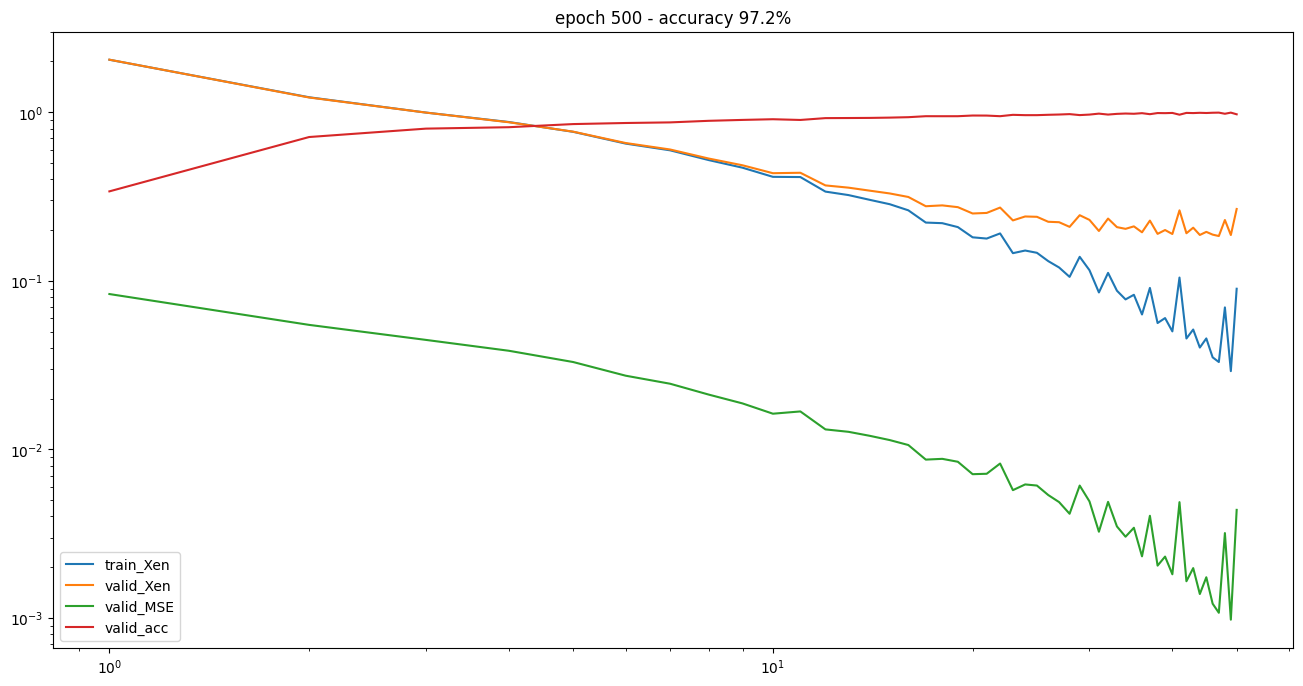

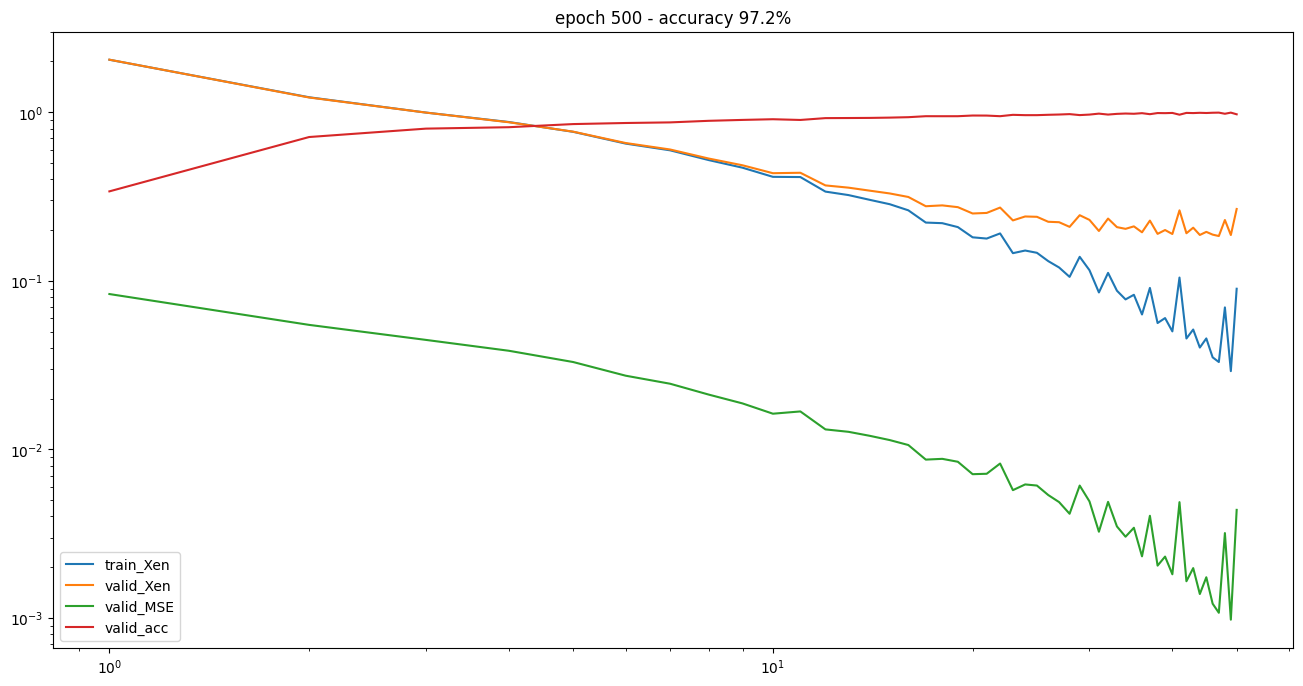

In [13]:
# Hyperparameters
layers_size = [784, 50, 50, 10]
# Training options
num_epochs = 500
batch_size = 1000
learning_rate = 2e-3
decay_rate = 0.9
delta = 1e-7

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()

grad_jit = jax.jit(jax.grad(cross_entropy_fast, argnums = 2))

MSE_fast = jax.jit(MSE)
acc_fast = jax.jit(accuracy)

cb = Callback(refresh_rate = 50)

r = [0 for _ in range(len(params))]
ro = decay_rate

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(x_train.shape[0]), batch_size, replace=True)
  grads = grad_jit(x_train[idx], y_train[idx], params)
  for i in range(len(params)):
    r[i] = ro * r[i] + (1 - ro) * grads[i] ** 2
    params[i] -= (learning_rate / (delta + np.sqrt(r[i]))) * grads[i]

  if epoch % 10 == 0:
    history_train_Xen.append(cross_entropy_fast(x_train, y_train, params))
    history_valid_Xen.append(cross_entropy_fast(x_test, y_test, params))
    history_valid_MSE.append(MSE_fast(x_train, y_train, params))
    history_valid_acc.append(acc_fast(x_train, y_train, params))

  cb(epoch)

## Testing

Load the dataset `sample_data/mnist_test.csv` and compute the accuracy of the classifier on this dataset.

In [14]:
data_test = np.genfromtxt("mnist_test.csv", delimiter=",")
print(data_test.shape)

labels_valid = data_test[:, 0]
x_valid = data_test[:, 1:] / 255
y_valid = np.zeros((x_valid.shape[0], 10))

for i in range(len(y_valid)):
  y_valid[i][int(labels_valid[i])] = 1
x_valid.shape, y_valid.shape

(10000, 785)


((10000, 784), (10000, 10))

Use the following script to visualize the predictions on a bunch of test images.

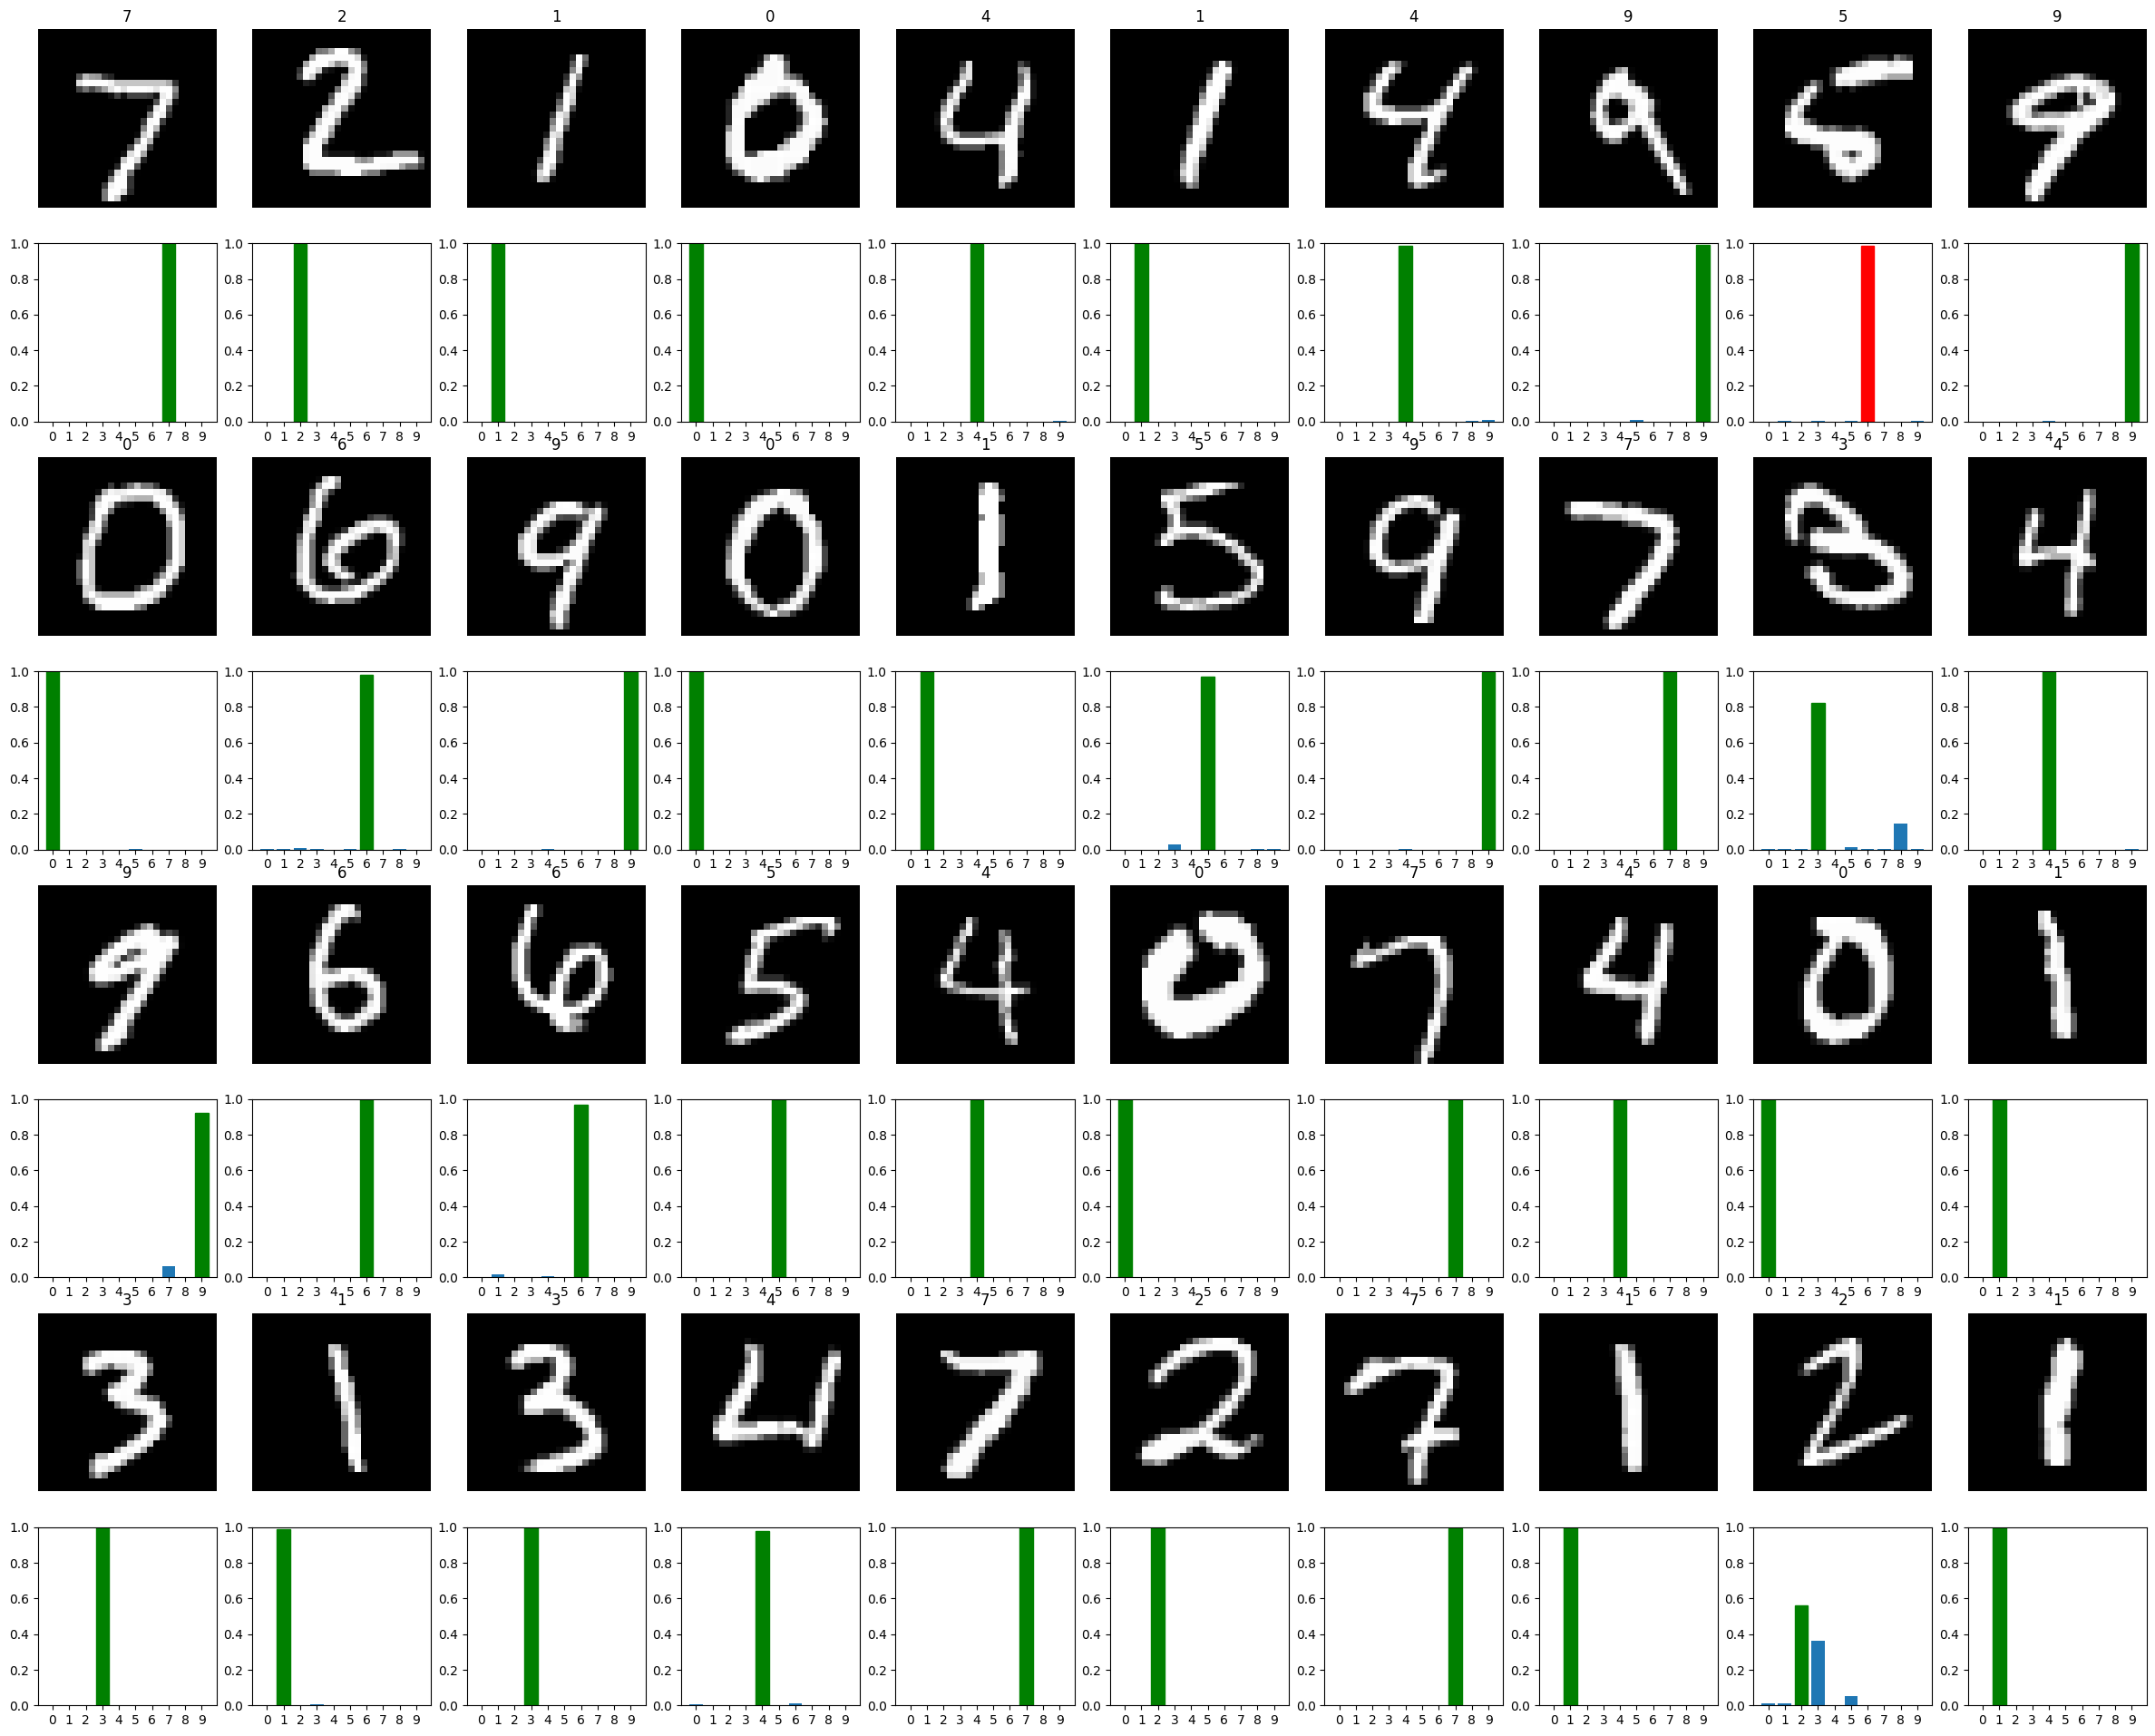

In [15]:
offset = 0
n_images = 40

images_per_row = 10
y_predicted = ANN(x_valid[offset:offset + n_images], params)

def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0,1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
      color = 'green'
    else:
      color = 'red'
    myplot[label_predicted].set_color(color)

import math
n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize = (3 * images_per_row, 3 * n_rows))
row = 0
col = 0
for i in range(n_images):
  axs[2 * row, col].imshow(x_valid[offset + i].reshape((28,28)), cmap='gray')
  axs[2 * row, col].set_title(int(labels_valid[offset + i]))
  axs[2 * row,col].axis('off')

  draw_bars(axs[2 * row + 1,col], y_predicted[i], labels_valid[offset + i])

  col += 1
  if col == images_per_row:
    col = 0
    row += 1

# Adversarial attacks

You have trained your classifier. Cool, isn't it? Let us now try to fool it.

Consider the last image of the training set. Visualize it and visualize the associated predictions of the classifier.

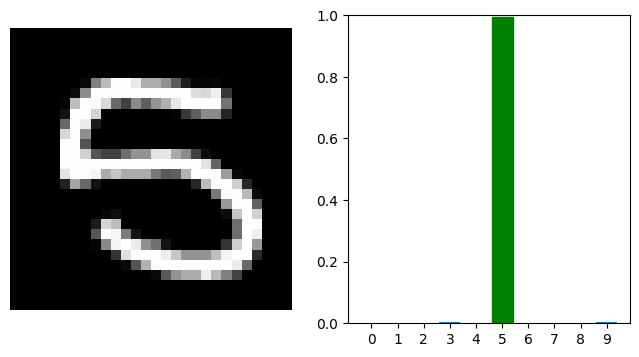

In [16]:
x = np.array([x_data[-1]])
y = y_data[-1]
label = np.argmax(y)

_, axs = plt.subplots(1,2, figsize = (8,4))
axs[0].imshow(x.reshape((28,28)), cmap = 'gray')
axs[0].axis('off')

y_pred = ANN(x, params)[0]

draw_bars(axs[1], y_pred, label)

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake.
See e.g. [this article](https://www.wired.com/story/tesla-speed-up-adversarial-example-mgm-breach-ransomware/)

To hack the classifier, compute the gradient of cross entropy loss funcion with respect to the input (not to the parameters!). Then, superimpose a multiple of the gradient to the original image.

Visualize the original and the hacked images and the corresponding prediction of the classifier.

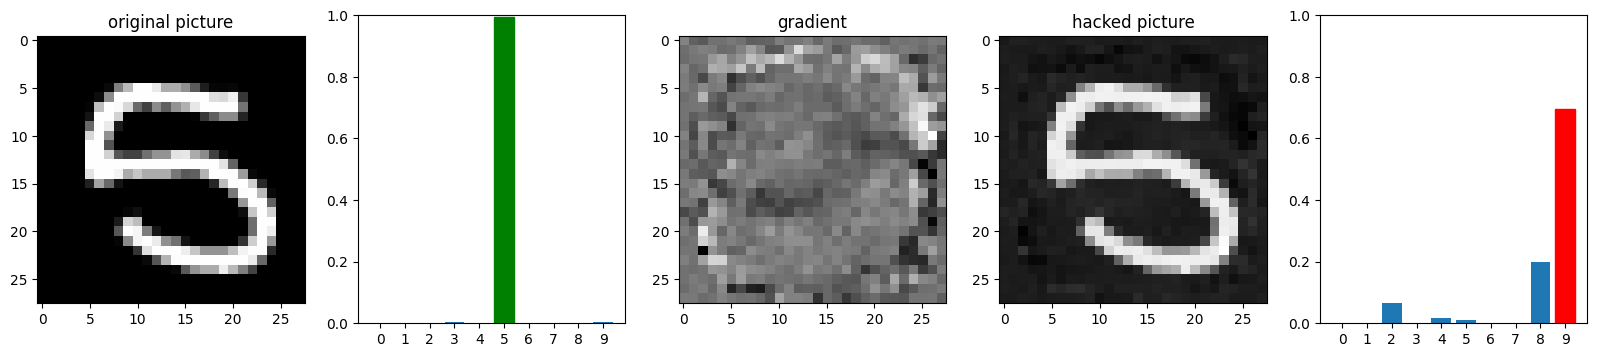

In [26]:
grad = jax.jit(jax.grad(cross_entropy, argnums=0))
gradient = grad(x, y, params)
x_updated = x - 0.1 * gradient
y_updated = ANN(x_updated, params)[0]

_, axs = plt.subplots(1 ,5, figsize=(20, 4))
axs[0].imshow(x.reshape((28, 28)), cmap = 'gray')
axs[0].set_title('original picture')
draw_bars(axs[1], y_pred, label)
axs[2].imshow(gradient.reshape((28, 28)), cmap = 'gray')
axs[2].set_title('gradient')
axs[3].imshow(x_updated.reshape((28, 28)), cmap = 'gray')
axs[3].set_title('hacked picture')
draw_bars(axs[4], y_updated, label)

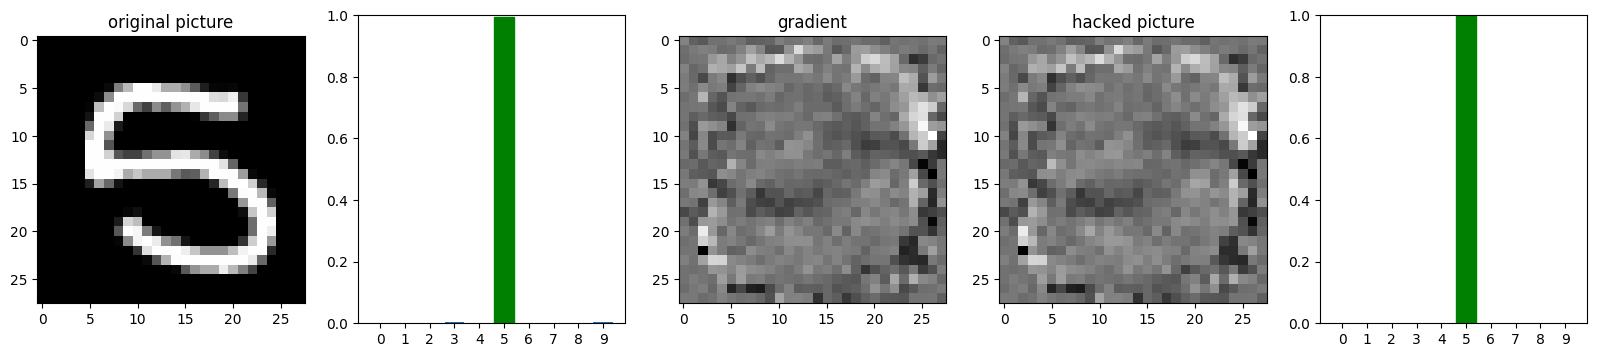

In [39]:
x_updated = x + 10 * gradient
y_updated = ANN(x_updated, params)[0]

_, axs = plt.subplots(1 ,5, figsize=(20, 4))
axs[0].imshow(x.reshape((28, 28)), cmap = 'gray')
axs[0].set_title('original picture')
draw_bars(axs[1], y_pred, label)
axs[2].imshow(gradient.reshape((28, 28)), cmap = 'gray')
axs[2].set_title('gradient')
axs[3].imshow(x_updated.reshape((28, 28)), cmap = 'gray')
axs[3].set_title('hacked picture')
draw_bars(axs[4], y_updated, label)

In [19]:
# Adversarial Attack can be used to train very robust models in Deep Learning

In [20]:
ANN(x, params)[0]

Array([8.1837061e-05, 6.0727598e-07, 4.2637627e-04, 2.5648186e-03,
       7.0696449e-05, 9.9327689e-01, 2.2869697e-04, 3.2657535e-06,
       1.7822557e-04, 3.1685396e-03], dtype=float32)

In [33]:
def loss(img, params):
  vec = np.zeros(10)
  vec[5] = 1
  pred = ANN(img.reshape((1, -1)), params)[0]
  return jnp.mean(jnp.square(jnp.array(vec) - pred))

grad_fast = jax.jit(jax.grad(loss, argnums=0))
w = np.random.normal(0, 1, (784, ))
w.shape

(784,)

In [34]:
from tqdm.notebook import tqdm

epochs = range(500)
lr = 1e-1

history_train = list()

m = np.zeros(w.shape)
v = np.zeros(w.shape)
eps = 1e-8
beta_1, beta_2 = 0.9, 0.999

for epoch in tqdm(epochs):
    grads = grad_fast(w, params)

    m = beta_1 * m + (1 - beta_1) * grads
    v = beta_2 * v + (1 - beta_2) * np.square(grads)

    m_hat = m / (1 - np.power(beta_1, epoch + 1))
    v_hat = v / (1 - np.power(beta_2, epoch + 1))

    w -= lr * m_hat / (np.sqrt(v_hat) + eps)

    history_train.append(loss(w, params))

  0%|          | 0/500 [00:00<?, ?it/s]

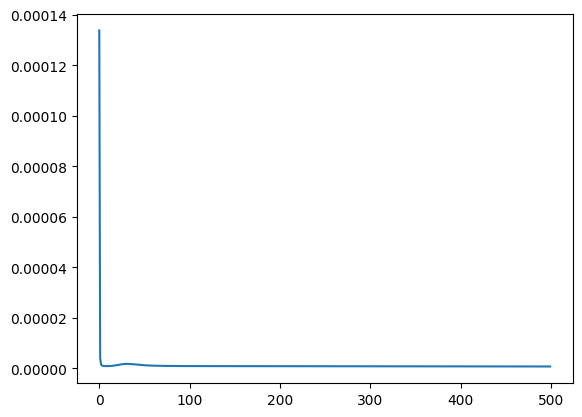

In [35]:
plt.plot(history_train);

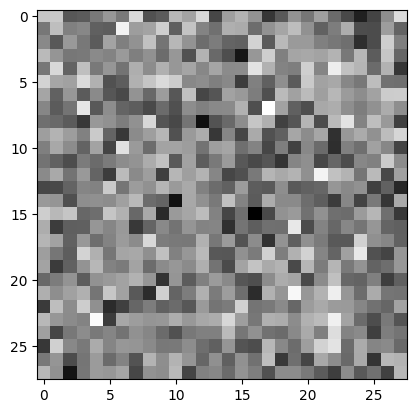

In [36]:
plt.gray()
plt.imshow(w.reshape((28, 28)));
# This is the most clear representation of a 5 --> very strange and problematic

In [37]:
ANN(w.reshape((1, -1)), params)[0]

Array([1.61312946e-05, 4.10379812e-07, 9.00343584e-05, 1.27864489e-03,
       1.58301682e-05, 9.97626007e-01, 1.15706236e-04, 1.01960518e-06,
       4.32631969e-05, 8.13007122e-04], dtype=float32)